# ImageMaskIterator Demonstration

An iterator is a simple datastructure that loads and streams images "on-the-fly" (only when it is required) instead of loading the whole dataset at once.

In [ ]:
%matplotlib inline

import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model, layers, models

from tensorflow.keras.utils import Sequence
from keras.preprocessing.image import Iterator, ImageDataGenerator
import keras.backend as K

print(tf.__version__)

# DRIVE
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/CYBERSCOPE/')

!nvidia-smi

2.4.1
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Tue Mar  9 17:22:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    31W /  70W |  14828MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+------------------------------

In [ ]:
class ImageMaskGenerator(Sequence):
    """
    Generates images and masks for performing data augmentation in Keras.
    We inherit from Sequence (instead of directly using the keras ImageDataGenerator)
    since we want to perform augmentation on both the input image AND the mask 
    (target). This mechanism needs to be implemented in this class. This class
    also allows to implement new augmentation transforms that are not implemented
    in the core Keras class (illumination, etc.).
    See : https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    and https://stackoverflow.com/questions/56758592/how-to-customize-imagedatagenerator-in-order-to-modify-the-target-variable-value
    for more details.
    """

    def __init__(self, X_set, Y_set=None, # input images and masks
                 batch_size: int=32, dim: tuple=(512, 512), n_channels: int=1, # informations
                 shuffle: bool=True, normalize=True, reshape=False, # preprocessing params
                 **kwargs): # data augmentation params
        """
        X_set (list, array or str): pointer to the images (Bright-Field). If str
        the string is assumed to be pointing at some directory.
        Y_set (list; array or str): pointer to the masks (target). If str
        the string is assumed to be pointing at some directory.
        batch_size (int): size of the batch
        dim (tuple): dimension of the images
        n_channels (int) : number of channels of the images (1 for TIF)
        shuffle (bool): Shuffle the dataset between each training epoch
        normalize (bool): normalize the images and masks in the beginning
        reshape (bool): reshape the images and masks to (dim, dim, n_channels)
        histogram_equalization (bool): perform histogram equalization to improve
        rendering using opencv
        horiz_flip_percent ()
        vert_flip_percent
        """
        # super().__init__(n, batch_size, shuffle, seed)
        self.dim = dim
        self.im_size = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        
        # build the X_set in an array. If X_set is a directory containing images
        # then self.X_set doesn't contains the images but the file names, but it
        # is transparent for the user.
        if type(X_set) == list:
            self.from_directory_X = False
            self.X_set = np.array(X_set)
        elif type(X_set) == np.array:
            self.from_directory_X = False
            self.X_set = X_set
        elif type(X_set) == str: # assuming a path
            self.from_directory_X = True
            self.X_dir = X_set # path to the images dir
            self.X_set = np.array(sorted(os.listdir(X_set))) # sorted guarantees the order
        else:
            raise TypeError("X_set should be list, array or path to dir")
        
        # build the Y_set in an array
        if type(Y_set) == list:
            self.from_directory_Y = False
            self.Y_set = np.array(Y_set)
        elif type(Y_set) == np.array:
            self.from_directory_Y = False
            self.Y_set = Y_set
        elif type(Y_set) == str: # assuming a path
            self.from_directory_Y = True
            self.Y_dir = Y_set # path to the masks dir
            self.Y_set = np.array(sorted(os.listdir(Y_set)))
        else:
            raise TypeError("X_set should be list, array or path to dir")

        # Check if there are the same number of images in X (images) and Y (masks)
        assert self.X_set.shape[0] == self.Y_set.shape[0]

        self.shuffle = shuffle

        # Preprocessing parameters
        self.normalize = normalize
        self.reshape = reshape

        # The Keras generator that will be used to perform data augmentation 
        self.generator = ImageDataGenerator(**kwargs)

        # Initialize the indices (shuffle if asked)
        self.on_epoch_end()

    def __len__(self) -> int:
        """
        Number of batches per epoch : we evenly split the train set into samples
        of size batch_size.
        """
        return int(np.floor(self.X_set.shape[0] / self.batch_size))

    def __getitem__(self, index: int):
        """
        Generate one batch of data.
        """
        # Generate indices corresponding to the images in the batch
        indices = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate the batch
        X, Y = self.__data_generation(indices)
        return X, Y

    def on_epoch_end(self):
        """
        Updates indexes after each epoch. self.indexes is used to retrieve the
        samples and organize them into batches.
        If shuffle : randomizes the order of the samples in order to give 
        different training batches at each epoch.
        """
        self.indexes = np.arange(self.X_set.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs: [int]):
        """
        Generates data containing batch_size samples. This is where we load the
        images if they are in a directory, and apply transformations to them.
        """ 
        # Load data (from directory or from X_set depending on the given data)
        if self.from_directory_X:
            batch_X = []
            for im in list_IDs:
                batch_X.append(imageio.imread(f"{self.X_dir}/{self.X_set[im]}"))
            batch_X = np.array(batch_X)            
        else:
            batch_X = self.X_set[list_IDs]

        if self.from_directory_Y:
            batch_Y = []
            for im in list_IDs:
                batch_Y.append(imageio.imread(f"{self.Y_dir}/{self.Y_set[im]}"))
            batch_Y = np.array(batch_Y) 
        else:
            batch_Y = self.Y_set[list_IDs]

        # Preprocessing
        if self.reshape:
            batch_X = self.perf_reshape(batch_X)
            batch_Y = self.perf_reshape(batch_Y)

        if self.normalize:
            batch_X = self.perf_normalize(batch_X)
            batch_Y = self.perf_normalize(batch_Y)

        # Add a channel axis (mandatory for Keras data augmentation)
        batch_X = np.expand_dims(batch_X, axis=-1)
        batch_Y = np.expand_dims(batch_Y, axis=-1)

        # Perform the SAME transformation on the image and on the mask
        for i, (img, mask) in enumerate(zip(batch_X, batch_Y)):
            transform_params = self.generator.get_random_transform(img.shape)
            batch_X[i] = self.generator.apply_transform(img, transform_params)
            batch_Y[i] = self.generator.apply_transform(mask, transform_params)

        return batch_X, batch_Y

    # Preprocessing functions
    def perf_reshape(self, images):
        new_batch = np.empty((self.batch_size, *self.im_size))
        for i, img in enumerate(images):
            new_batch[i] = cv2.resize(img, self.im_size, interpolation=cv2.INTER_AREA)
        return new_batch

    def perf_normalize(self, images):
        new_batch = np.empty(images.shape)
        for i, img in enumerate(images):
            new_batch[i] = img / np.max(img)
        return new_batch

    # Extra data augmentation trasnforms

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


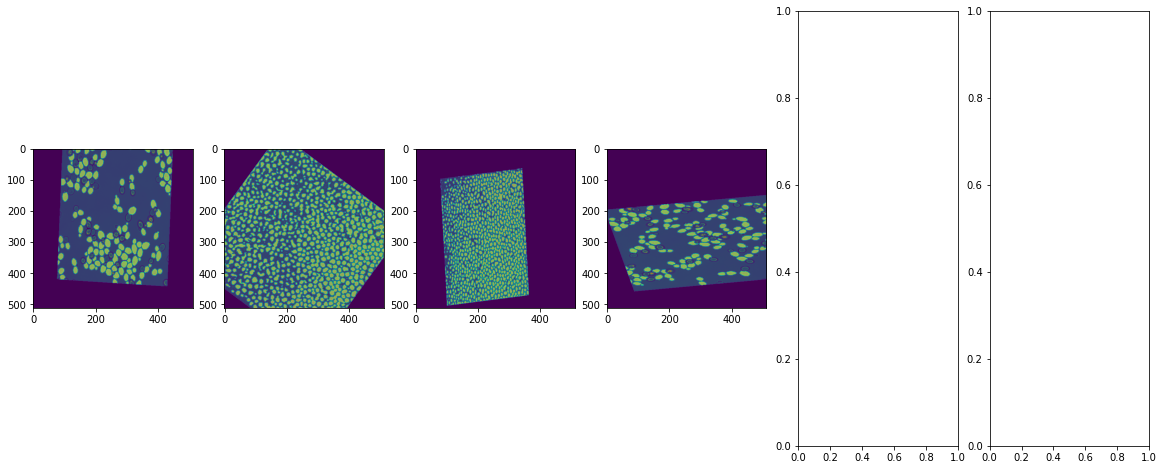

In [ ]:
data_path = "/content/gdrive/MyDrive/CYBERSCOPE/Data/training-cell_v3"
bf_dir, mask_dir = f"{data_path}/images/", f"{data_path}/masks/"

# cf. la doc Keras pour voir tout ce qu'il est possible de faire
# https://keras.io/api/preprocessing/image/
# voir aussi la librairie imgaug pour implementer de nouvelles transfo
augmentation_params = dict(zoom_range=[0.9, 2.0],
                           vertical_flip=True,
                           horizontal_flip=True,
                           rotation_range=360,
                           height_shift_range=0.2,
                           width_shift_range=0.2,
                           fill_mode="constant", cval=0)
bat_size = 4
generator = ImageMaskGenerator(bf_dir, mask_dir, 
                               batch_size=bat_size, dim=(512, 512), n_channels=1, 
                               shuffle=True, normalize=True, reshape=True,
                                **augmentation_params)

fig, ax = plt.subplots(1, 6, figsize=(20, 8))

# get the first batch from directory
ims, masks = generator[0]

for i, (img, mask) in enumerate(zip(ims[:6], masks[:6])):
    ax[i].imshow(img.squeeze(-1))
    ax[i].imshow(mask.squeeze(-1), alpha=0.5)

In [ ]:
def get_unet(nbr,x,y):
    """
    nbr (int): kernel side
    x (int): image height
    y (int): image width
    """
    entree=layers.Input(shape=(x, y, 1), dtype='float16')

    result=layers.Conv2D(nbr, 3, activation='relu', padding='same')(entree)
    result=layers.BatchNormalization()(result)
    result=layers.Conv2D(nbr, 3, activation='relu', padding='same')(result)
    result1=layers.BatchNormalization()(result)

    result=layers.MaxPool2D()(result1)

    result=layers.Conv2D(2*nbr, 3, activation='relu', padding='same')(result)
    result=layers.BatchNormalization()(result)
    result=layers.Conv2D(2*nbr, 3, activation='relu', padding='same')(result)
    result2=layers.BatchNormalization()(result)

    result=layers.MaxPool2D()(result2)

    result=layers.Conv2D(4*nbr, 3, activation='relu', padding='same')(result)
    result=layers.BatchNormalization()(result)
    result=layers.Conv2D(4*nbr, 3, activation='relu', padding='same')(result)
    result3=layers.BatchNormalization()(result)

    result=layers.MaxPool2D()(result3)

    result=layers.Conv2D(4*nbr, 3, activation='relu', padding='same')(result)
    result=layers.BatchNormalization()(result)
    result=layers.Conv2D(4*nbr, 3, activation='relu', padding='same')(result)
    result4=layers.BatchNormalization()(result)

    result=layers.MaxPool2D()(result4)

    result=layers.Conv2D(8*nbr, 3, activation='relu', padding='same')(result)
    result=layers.BatchNormalization()(result)
    result=layers.Conv2D(4*nbr, 3, activation='relu', padding='same')(result)
    result=layers.BatchNormalization()(result)

    result=layers.UpSampling2D()(result)
    result=tf.concat([result, result4], axis=3)

    result=layers.Conv2D(8*nbr, 3, activation='relu', padding='same')(result)
    result=layers.BatchNormalization()(result)
    result=layers.Conv2D(4*nbr, 3, activation='relu', padding='same')(result)
    result=layers.BatchNormalization()(result)

    result=layers.UpSampling2D()(result)
    result=tf.concat([result, result3], axis=3)

    result=layers.Conv2D(4*nbr, 3, activation='relu', padding='same')(result)
    result=layers.BatchNormalization()(result)
    result=layers.Conv2D(2*nbr, 3, activation='relu', padding='same')(result)
    result=layers.BatchNormalization()(result)

    result=layers.UpSampling2D()(result)
    result=tf.concat([result, result2], axis=3)

    result=layers.Conv2D(2*nbr, 3, activation='relu', padding='same')(result)
    result=layers.BatchNormalization()(result)
    result=layers.Conv2D(nbr, 3, activation='relu', padding='same')(result)
    result=layers.BatchNormalization()(result)

    result=layers.UpSampling2D()(result)
    result=tf.concat([result, result1], axis=3)

    result=layers.Conv2D(nbr, 3, activation='relu', padding='same')(result)
    result=layers.BatchNormalization()(result)
    result=layers.Conv2D(nbr, 3, activation='relu', padding='same')(result)
    result=layers.BatchNormalization()(result)

    sortie=layers.Conv2D(1, 1, activation='sigmoid', padding='same')(result)

    model=models.Model(inputs=entree, outputs=sortie)
    return model

unet = get_unet(32, 512, 512)
print(unet.summary())

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_152 (Conv2D)             (None, 512, 512, 32) 320         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_144 (BatchN (None, 512, 512, 32) 128         conv2d_152[0][0]                 
__________________________________________________________________________________________________
conv2d_153 (Conv2D)             (None, 512, 512, 32) 9248        batch_normalization_144[0][0]    
____________________________________________________________________________________________

## Code a weighted binary crossentropy

This step is important because we are facing a class imbalance problem : the 0 class (i.e. background) are way more numerous than the 1 class (i.e. yeast pixels).

In [ ]:
class WeightedBinaryCrossEntropy():

    def __init__(self, class_weight={0: 0.5, 1: 0.5}):
        self.class_weight = class_weight
        self.__name__ = "binary_cross_entropy"

    def __call__(self, Y_true, Y_pred):
        """
        Compute the weights binary cross entropy for a given mask Y_true and a given
        prediction Y_pred.
        """
        sample_weight = {0: 0.2, 1: 0.8}
        y_true = K.clip(Y_true, K.epsilon(), 1-K.epsilon())
        y_pred = K.clip(Y_pred, K.epsilon(), 1-K.epsilon())
        logloss = -(y_true * K.log(y_pred) * self.class_weight[1] 
                    + (1 - y_true) * K.log(1 - y_pred) * self.class_weight[0] )
        return K.mean(logloss, axis=-1)

## Train the model

In [ ]:
weights = {0: 0.99, 1: 0.01}
weighted_binary_crossentropy = WeightedBinaryCrossEntropy(class_weight=weights)

unet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=weighted_binary_crossentropy,
    metrics=["accuracy"],
)

unet.fit(generator, epochs=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Epoch 1/20
7/7 [==============================] - 4s 251ms/step - loss: 0.0081 - accuracy: 0.8497
Epoch 2/20
7/7 [==============================] - 2s 252ms/step - loss: 0.0086 - accuracy: 0.8074
Epoch 3/20
7/7 [==============================] - 2s 251ms/step - loss: 0.0090 - accuracy: 0.7815
Epoch 4/20
7/7 [==============================] - 2s 253ms/step - loss: 0.0078 - accuracy: 0.8114
Epoch 5/20
7/7 [==============================] - 2s 251ms/step - loss: 0.0061 - accuracy: 0.8487
Epoch 6/20
7/7 [==============================] - 2s 251ms/step - loss: 0.0072 - accuracy: 0.8153
Epoch 7/20
7/7 [==============================] - 2s 253ms/step - loss: 0.0071 - accuracy: 0.8233
Epoch 8/20
7/7 [==============================] - 2s 251ms/step - loss: 0.0067 - accuracy: 0.8360
Epoch 9/20
7/7 [==============================] - 2s 254ms/step - loss: 0.0061 - accuracy: 0.8654
Epoch 10/20
7/7 [==============================] - 2s 253ms/step - loss: 0.0082 - accuracy: 0.8027
Epoch 11/20
7/7 [==

## Perform inference

In [ ]:
test_img_path = "/content/gdrive/MyDrive/CYBERSCOPE/Data/BF_f0001-1img.tif"
test_img = imageio.imread(test_img_path)

test_img2 = cv2.resize(test_img, (512, 512), interpolation=cv2.INTER_AREA)
test_img2 = test_img2 / np.max(test_img2)
test_img2 = np.expand_dims(test_img2, axis=-1)
test_img2 = np.expand_dims(test_img2, axis=0)
print(f"Image size : {test_img2.shape}")

pred = unet.predict(test_img2)
# mask
# pred = 255 * (pred > 127)

Image size : (1, 512, 512, 1)


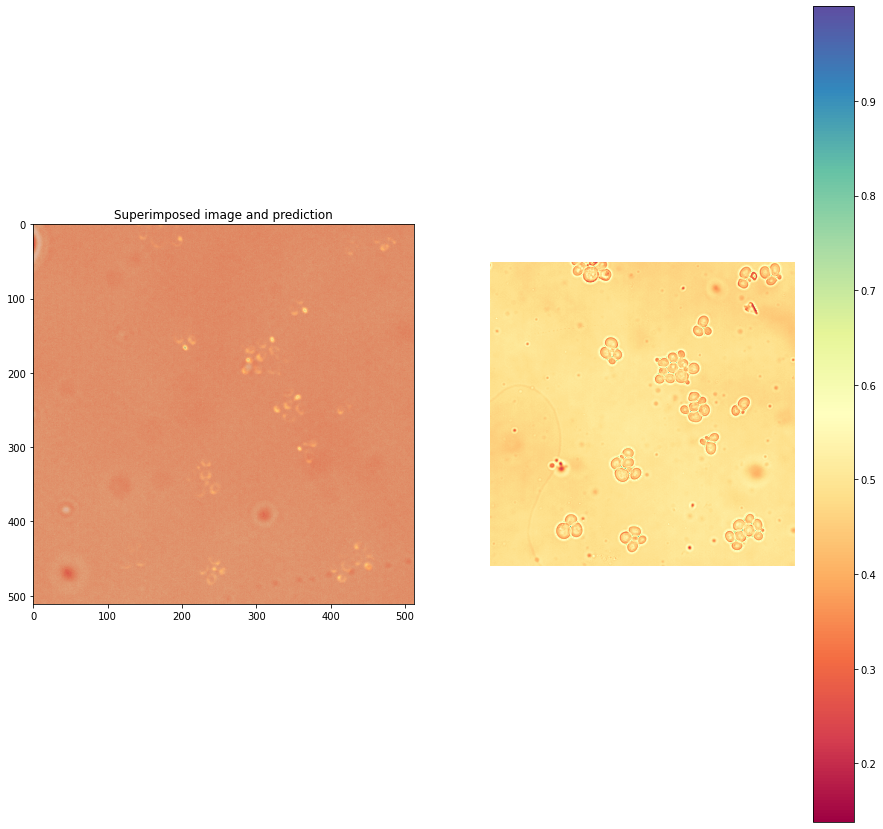

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
im = ax[0].imshow(test_img, cmap="Spectral")
im = ax[0].imshow(pred.squeeze(-1).squeeze(0), cmap="Spectral", alpha=0.3)
ax[0].set_title("Superimposed image and prediction")
im2 = ax[1].imshow((np.sqrt(test_img2 - pred) ** 2).squeeze(-1).squeeze(0), cmap="Spectral")
plt.axis("off")
# plt.colorbar(im)
plt.colorbar(im2)

## Save model

In [ ]:
save_model_path = "/content/gdrive/MyDrive/CYBERSCOPE/Models/training-cell-30imgs-ep20-bs4_date09-03-2021-19-18"
unet.save(save_model_path)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/CYBERSCOPE/Models/training-cell-30imgs-ep20-bs4_date09-03-2021-19-18/assets
